<a href="https://colab.research.google.com/github/sanmeshh/Synapse_LP/blob/week9/week4NLPSanmesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SYNAPSE 2024-25 NLP Task 4**

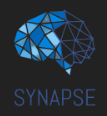






We have been exploring various Deep Learning techniques till now, and all of them somehow or the other through their shortcomings lead us to the architecture that shaped the future of NLP - the Transformer Model. Going further than its predecessor models, the Transformer architecture understands context in a way that other deep learning models like LSTM's and RNN's fail to do.

In this notebook, we will attempt to build a Transformer from scratch, particulary focusing on the Self Attention layer. A few things to note before we start:

1) This is not the **complete** and **latest** understanding of the Transformer architecture, implementing that is beyond the scope of any of us in this college as of now. This is an earlier iteration of the Attention Layer but is very much similar in its key concepts.

2) You might notice that not too many cells are given for you to complete in the Self Attention. This task is as much of understanding what is occuring in that code as it is a challenge to fill the blank sections of the code so that you don't feel overwhelmed but understand ki chal kya raha hai.

3) Don't fret if you feel overwhelmed by this, it IS difficult. Take your time, read up on resources and mainly focus on learning rather than just finishing off the task. Ok rant over

To get an idea of what we want to do and how we plan to get there, check these videos out: (StatQuest ftw):

Seq2Seq enc-dec neural networks - https://youtu.be/L8HKweZIOmg?si=lEqJj5RNRvuaOf-e

Attention in neural networks - https://youtu.be/PSs6nxngL6k?si=1NjFu2lyUhkVoIRW

Reviews.csv link download - https://drive.google.com/file/d/1T558yfJNALPogaILkbAvYO7C_P3qZEAT/view?usp=sharing

### Importing all the necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import re
import tensorflow as tf
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from tensorflow.keras.layers import Attention, Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
from tensorflow.python.keras import backend as K
import gc
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


### Global Variables

These variables control key aspects of a language model for tasks like summarizing text. They set limits on input and output lengths (`max_len_text` and `max_len_summary`), determine how many times the model learns from the data (`epochs`), and specify the amount of data used (`number_of_datapoints`). The line `logger = tf.get_logger()` sets up a way to track the model's progress as it learns.

In [ ]:
max_len_text=80
max_len_summary=10
epochs=10 ### PREFERABLY 50 must be done; for testing purposes use 10
number_of_datapoints=100000

logger = tf.get_logger()

Map contractions to their original phrase to make it easier to have a consistent representation of those terms and avoid mistakes in understanding context.

In [ ]:
contraction_mapping = {
    "ain't": "is not", "aren't": "are not", "can't": "cannot", "'cause": "because",
    "could've": "could have", "couldn't": "could not", "didn't": "did not",
    "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not",
    "haven't": "have not", "he'd": "he would", "he'll": "he will", "he's": "he is",
    "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have",
    "I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
    "i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have",
    "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will",
    "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam",
    "mayn't": "may not", "might've": "might have", "mightn't": "might not",
    "mightn't've": "might not have", "must've": "must have", "mustn't": "must not",
    "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
    "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
    "she'd": "she would", "she'd've": "she would have", "she'll": "she will",
    "she'll've": "she will have", "she's": "she is", "should've": "should have",
    "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
    "so's": "so as", "this's": "this is", "that'd": "that would",
    "that'd've": "that would have", "that's": "that is", "there'd": "there would",
    "there'd've": "there would have", "there's": "there is", "here's": "here is",
    "they'd": "they would", "they'd've": "they would have", "they'll": "they will",
    "they'll've": "they will have", "they're": "they are", "they've": "they have",
    "to've": "to have", "wasn't": "was not", "we'd": "we would",
    "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
    "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will",
    "what'll've": "what will have", "what're": "what are", "what's": "what is",
    "what've": "what have", "when's": "when is", "when've": "when have",
    "where'd": "where did", "where's": "where is", "where've": "where have",
    "who'll": "who will", "who'll've": "who will have", "who's": "who is",
    "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
    "won't": "will not", "won't've": "will not have", "would've": "would have",
    "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
    "y'all'd": "you all would", "y'all'd've": "you all would have",
    "y'all're": "you all are", "y'all've": "you all have",
    "you'd": "you would", "you'd've": "you would have", "you'll": "you will",
    "you'll've": "you will have", "you're": "you are", "you've": "you have"
}

### Utility Data Preprocessing functions

In [ ]:
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    #removes html tags from the text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub(r'"', '',newString)#Write regex to substitute occurences of double quotes(") with a blank space('')
    newString =newString.split()
    newString= [contraction_mapping[word] if word in contraction_mapping else word for word in newString]
    newString=' '.join(newString) #Split newString into words, contract them using contraction_mapping if needed and join back into a string
    newString =re.sub(r"'s\b",' ',newString)
    newString =re.sub("[^a-zA-Z]", " ", newString)
    newString=newString.split()
    tokens = [i for i in newString if i not in set(stopwords.words("english"))] #return a list of words after removing stopwords
    long_words=[]
    for i in tokens:
      if len(i)>=3:
        long_words.append(i)

        #Append only if length of word >= 3

    return (" ".join(long_words)).strip()

In [ ]:
def summary_cleaner(text):
    newString =re.sub(r'"','',text)  #Write regex to substitute occurences of double quotes(") with a blank space('')
    newString =newString.split()
    #this basically means this [(contraction_mapping[word] for word  if word in contraction_mapping else word )for word in newString]
    newString= [contraction_mapping[word] if word in contraction_mapping else word for word in newString]
    newString=' '.join(newString) #Same contraction_mapping wala code
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:
            newString=newString+i+' '
    return newString

### Data Preprocessing

In [ ]:
data=pd.read_csv("/content/gdrive/MyDrive/Reviews.csv",nrows=number_of_datapoints)

In [ ]:
data.head()



,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


In [ ]:
#Drop duplicate values from the Text columns
data['Text']=data['Text'].drop_duplicates()

#Drop null values from the dataset
data.dropna(inplace=True)


In [ ]:
from tqdm import tqdm

In [ ]:
cleaned_text = []
for t in tqdm(data['Text']):
    cleaned_text.append(text_cleaner(t))



100%|██████████| 88419/88419 [15:36<00:00, 94.44it/s]


In [ ]:
cleaned_summary = []
for t in tqdm(data['Summary']):
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
#Drop tuples in the data where there is a blank value ('') in data['cleaned_summary']




100%|██████████| 88419/88419 [00:01<00:00, 76539.79it/s]


In [ ]:
data = data[data['cleaned_summary'] != '']

In [ ]:
data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text,cleaned_summary
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,good quality dog food
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".",product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,not as advertised
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...",confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat famil...,delight says it all
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,cough medicine
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal.",great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,great taffy
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99996,B000LQORDE,A2P7HIRYYWVOBD,Mason,2,5,5,1254096000,yummy!,I just love it and will buy another box when I'm done with last one!,love buy another box done last one,yummy
99996,99997,B000LQORDE,A1K0ZH5MQFBA77,jennilight,2,5,4,1250985600,Tastes like More!,"My late father in law used to have a rating system for meals: if it was particularly tasty, he'd say ""This tastes like more!"" That's exactly how I felt the first time I tried a spicy picante ramyu...",late father law used rating system meals particularly tasty would say tastes like exactly felt first time tried spicy picante ramyun ordered whim featured gold box deal would enjoyed ramen noodles...,tastes like more
99997,99998,B000LQORDE,A29FRN2O7LWINL,T. Tsai,2,5,5,1237766400,Great ramen,"This is my favorite brand of Korean ramen. It is spicy so if you are not used to eating spicy food, make sure you don't use all of the spice pack. If you add an egg to the soup, it makes a great s...",favorite brand korean ramen spicy used eating spicy food make sure use spice pack add egg soup makes great snack,great ramen
99998,99999,B000LQORDE,A9Q950IPXJR1D,"Lynda ""casual customer""",2,5,4,1237161600,Spicy!!,"I do like these noodles although, to say they are spicy is somewhat of an understatement. No one else in the family tolerates spicy very well so, seeing these, I was looking forward to an extra li...",like noodles although say spicy somewhat understatement one else family tolerates spicy well seeing looking forward extra little something palate disappointed completely honest usually drain liqui...,spicy


In [ ]:
data['cleaned_summary']="_START_ "+data['cleaned_summary']+" _END_"#Add a '_START_ ' and ' _END_' tag at the start and end of every data point of data['cleaned_summary']

In [ ]:
for i in range(5):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print("\n")

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: _START_ good quality dog food  _END_


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: _START_ not as advertised  _END_


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: _START_ delight says it all  _END_


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: _START_ cough medicine  _END_


Review: great taffy great price wide assortment yummy taffy delivery quick taffy lo

In [ ]:
for i in range(5):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print("\n")

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: _START_ good quality dog food  _END_


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: _START_ not as advertised  _END_


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: _START_ delight says it all  _END_


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: _START_ cough medicine  _END_


Review: great taffy great price wide assortment yummy taffy delivery quick taffy lo

### Analysis of Sentence and Summary Length

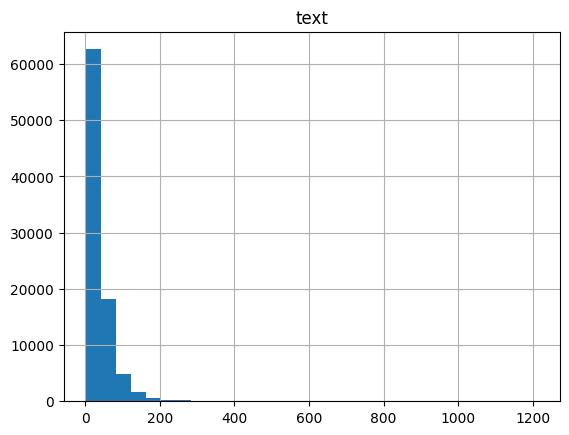

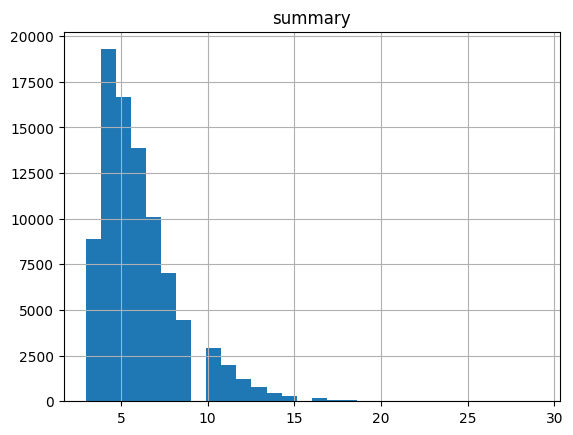

In [ ]:
text_word_count = []
summary_word_count = []

text_word_count = [len(text.split()) for text in data['cleaned_text']]
summary_word_count = [len(summary.split()) for summary in data['cleaned_summary']]

plt.hist(text_word_count, bins=30)
plt.title('text')
plt.grid()
plt.show()

plt.hist(summary_word_count, bins=30)
plt.title('summary')
plt.grid()
plt.show()



#Make 2 histograms depicting the word count in both Text and Summary columns


### Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True)

In [ ]:
#Create an instance of Tokenizer() and fit it on x_tr
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))
#convert text sequences into integer sequences for x_tr and x_val
x_tr_seq=x_tokenizer.texts_to_sequences(x_tr)
x_val_seq=x_tokenizer.texts_to_sequences(x_val)
#Add padding as you have done in the past
x_tr=pad_sequences(x_tr_seq,  maxlen=max_len_text, padding='post')
x_val=pad_sequences(x_val_seq, maxlen=max_len_text, padding='post')

x_voc_size=len(x_tokenizer.word_index) +1

In [ ]:
#Create an instance of Tokenizer() and fit it on x_tr
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))
#convert summary sequences into integer sequences for y_tr and y_val
y_tr_seq=y_tokenizer.texts_to_sequences(y_tr)
y_val_seq=y_tokenizer.texts_to_sequences(y_val)
#padding
y_tr=pad_sequences(y_tr_seq, maxlen=max_len_summary, padding='post')
y_val=pad_sequences(y_val_seq, maxlen=max_len_summary, padding='post')

y_voc_size =len(y_tokenizer.word_index) +1

## Architecture

For the Attention Layer:
In Keras, it is easy to create a custom layer that implements attention by subclassing the Layer class. The Keras guide lists clear steps for creating a new layer via subclassing. You’ll use those guidelines here. All the weights and biases corresponding to a single layer are encapsulated by this class. You need to write the __init__ method as well as override the following methods:

build(): The Keras guide recommends adding weights in this method once the size of the inputs is known. This method “lazily” creates weights. The built-in function add_weight() can be used to add the weights and biases of the attention layer.

call(): The call() method implements the mapping of inputs to outputs. It should implement the forward pass during training.

Watch this videos to get an in-depth understanding - https://www.youtube.com/watch?v=fdhojC37_Co

https://www.youtube.com/watch?v=W2rWgXJBZhU

Read so that you understand and implement - https://machinelearningmastery.com/adding-a-custom-attention-layer-to-recurrent-neural-network-in-keras/

And Read the research paper cited below!!!! :D

https://arxiv.org/abs/1706.03762 and the paper in the docstring of the function

\Don't break this code cell into smaller parts, as the tf.keras.backend.clear_session() would not be able to properly clear the session

In [ ]:
tf.keras.backend.clear_session()

latent_dim = 500

# Encoder
encoder_inputs =Input(shape=(max_len_text,)) #Input layer taking input size max_len_text
enc_emb = Embedding(x_voc_size, latent_dim, trainable=True)(encoder_inputs)


# LSTM 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True)
#Make LSTM layer with input latent_dim; ensure return_sequences and return_state is True because we want the layer to backpropagate
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# Add 2 more LSTM layers like above
encoder_lstm2=LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_output2,state_h2,state_c2=encoder_lstm2(encoder_output1)

encoder_lstm3=LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_outputs,state_h,state_c=encoder_lstm3(encoder_output2)

# Set up the decoder.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(y_voc_size,latent_dim,trainable=True)
#Similar to encoder layer embedding
dec_emb = dec_emb_layer(decoder_inputs)

# LSTM using encoder_states as initial state
decoder_lstm =LSTM(latent_dim,return_sequences=True,return_state=True) #Similar to encoder LSTM layer
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer,self).__init__(**kwargs)
         #inherit the parent class tf.keras.layers.Layer using the super keyword and include **kwargs in the argument

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        zeroth_index = 0 # specify the zeroth tensor shape
        first_index = 1 # specify the first tensor shape

        x = input_shape[zeroth_index][2]
        y = input_shape[first_index][2]

        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((y, x)),
                                   initializer='uniform',
                                   trainable=True)

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((x, x)),
                                   initializer='uniform',
                                   trainable=True)

        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((x, 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq =states[-1] #Extract the final state from the states list

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s =K.dot(encoder_full_seq,self.W_a) # Dot product of encoder_full_seq and W_a

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]#Extract the final state from the states list

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]


# Attention Layer
attn_layer = AttentionLayer(name="attention")

#initialize object AttentionLayer and pass name parameter
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention output and decoder LSTM output
#funny how we have used only attn_out in our below model
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 80)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 80, 500)        │     25,886,500 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 80, 500),      │      2,002,000 │ embedding[0][0]        │
│                           │ (None, 500), (None,    │                │                        │
│                           │ 500)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 80, 500),      │      2,002,000 │ lstm[0][0]             │
│                           │ (None, 500), (None,    │                │                        │
│                           │ 500)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 500)      │      7,072,000 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 80, 500),      │      2,002,000 │ lstm_1[0][0]           │
│                           │ (None, 500), (None,    │                │                        │
│                           │ 500)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 500),    │      2,002,000 │ embedding_1[0][0],     │
│                           │ (None, 500), (None,    │                │ lstm_2[0][1],          │
│                           │ 500)]                  │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention                 │ [(None, None, 500),    │        500,500 │ lstm_2[0][0],          │
│ (AttentionLayer)          │ (None, None, 80)]      │                │ lstm_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_layer              │ (None, None, 1000)     │              0 │ lstm_3[0][0],          │
│ (Concatenate)             │                        │                │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, None, 14144)    │     14,158,144 │ concat_layer[0][0]     │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 55,625,144 (212.19 MB)

 Trainable params: 55,625,144 (212.19 MB)

 Non-trainable params: 0 (0.00 B)

STATE YOUR UNDERSTANDING OF ATTENTION LAYER DESCRIPTIVELY :)

Write HEREEE -

Attention layer is the upgraded version of the encoder decoder model.
neural machine translation models belong to a family of encoder–
decoders.
A potential issue with this encoder–decoder approach is that a neural network needs to be able to compress all the necessary information of a source sentence into a fixed-length vector. This maymake it difficult for the neural network to cope with long sentences, especially those that are longer
than the sentences in the training corpus.
 By letting the decoder have an attention mechanism, we relieve the encoder from the burden of having to encode all information in the source sentence into a fixedlength vector. With this new approach the information can be spread throughout the sequence of annotations, which can be selectively retrieved by the decoder accordingly.

**In attention layer,BiLSTM layers are used in encoders.First the sequences of one langauage are taken as input in the input layer and are then converted into embedding layers. These embeddings layers are passed to the encoder layer.
BiLSTM layers are used in encoders.The hidden state vectors are used in the context vectors as usual but new a variable alpha which is a scalar weight is applied in the context vectors. The context vectors are the sum of the product of the alpha weights and hidden state vectors , context vector i the new weights are multiplied with each hidden state vector.**

**These context vectors , the output of the previous hidden state vector(Si) of the decoder and  the embedded input sequences of the other langauage (ofc in terms of machine translation) are sent as input to the decoder.This helps the  decoder to decide parts of the source sentence to pay attention. the appropriate word as given as output from the given layer as an embedding layer with the help of softmax layer.**






In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,
                  epochs=10,batch_size=512, validation_data=([x_val,y_val[:,:-1]],
                    y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/10
 19/156 ━━━━━━━━━━━━━━━━━━━━ 2:04:54 55s/step - loss: 7.1087

In [ ]:
gc.collect()

### Post Training Analysis & Testing

In [ ]:
#Plot loss and val_loss by extracting it from the history of the object

loss=history.history['loss']
val=history.history['val_loss']

plt.plot(loss,label='loss')
plt.plot(val,label='val_loss')

plt.xlabel("Range of loss")
plt.ylabel("Loss")
plt.title("History")

plt.legend()
plt.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
# encoder inference
#create a Model by specifying the inputs and the outputs (also consider h and c in output)
encoder_model=Model([encoder_inputs],[encoder_outputs]+[state_h,state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
#write a line similar for c
decoder_state_input_c=Input(shape=(latent_dim,))


decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)#Use the decoder embedding layer you made above and pass decoder input to it

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


#attention inference
attn_out_inf, attn_states_inf =attn_layer([decoder_hidden_state_input,decoder_outputs2]) # create an attention layer with the help of decoder_hidden_state_input and decoder_outputs2
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary. Again, you have created this layer above, so use that
decoder_outputs2 =decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq =np.zeros((1,1))

    # Choose the 'start' word as the first word of the target sequence according to its rank in the word-index/vocab
    target_seq[0, 0] = target_word_index['start']#1

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        # Write the code to predict the values of output_tokens, h, c based on our model

        output_tokens,h,c=decoder_model.predict([target_seq]+[e_out,e_h,e_c])

          #encoder_outputs(e_out) , hidden and cell state(e_h,e_c) are also used in prediction
          #since final state of encoder is set as the initial state of the decoder

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        #output tokens are just probabilities tensor ,shape=(1,1,14144)

        sampled_token = reverse_target_word_index[sampled_token_index+1]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Write code for the Exit condition: either hit max length or find the 'end' word.
            if(len(decoded_sentence)==max_len_text or sampled_token=='end'):
              stop_condition = True


        # Update the target sequence (of length 1).

        #the sampled_token_index gives the current word which will be used as an input in the next decoder state
        #therefore it is assigned to the target_seq which is used in decoder_model.predict function
        target_seq=np.zeros((1,1))
        target_seq[0,0]= sampled_token_index


        # Update internal states
        e_h,e_c=h,c


    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString = ''
    for i in input_seq:
      #!=0 is put since we have padded x_val with 0 with the help of padded_sequneces
        if(i != 0):
            newString = newString + reverse_source_word_index[i] + ' '
    return newString

    # write a code similar to that above, with some modifications in conditions


### Let's do some Generation

In [ ]:
i=1
print("Review:",seq2text(x_val[i]))
print("Original summary:",seq2summary(y_val[i]))
print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text))[:18])
print("\n")

End of task 4
--

### Synapse 2024-25